<a href="https://colab.research.google.com/github/dkalenov/ML-Trading/blob/1_unsupervised-learning/K_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Case Study

Traders who are particuarly keen on Pairs Trading, need a way to find pairs that:
    
    a) Are similar in risk and behaviour
    b) Are cointegrated

K-Means Clustering is a Clustering technique as to which a vast array of features can have their data compared with one another and grouped into clusters of similarity. The applications of this are vast as described in the theory sections of the course.

Once stocks/cryptocurrencies/FOREX pairs are grouped, they can then have cointegration calculations run against them to further help with statistical methods. Although cointegration is more a statistics method rather than Machine Learning, the code has been included here for convenience.

### Imports

In [1]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data extraction and management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics

# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

### Data Extraction

In [ ]:
# import yfinance as yf

# data = yf.download("BTC", "2017-01-01", "2024-03-28")
# data = data[["Open", "High", "Low", "Adj Close", "Volume"]]
# data.tail()

In [2]:
# Set Data Extraction parameters
start_date = "2017-01-01"
end_date = "2024-03-27"
file_name = "data/raw_data_etf.csv"
file_name_coint = "data/raw_data_coint_pairs.csv"
load_existing = False
load_coint_pairs = False

In [3]:
# Get New or Load Existing Data
# Allow 15 mins for new data
import os
import yfinance as yf

if not os.path.exists('data'):
    os.makedirs('data')

if not load_existing:
  symbols = get_nasdaq_symbols()
  symbols = symbols[(symbols["ETF"] == True) & (symbols["Market Category"] == "G")] # G = NASDAQ GLOBAL MARKET
  symbols = list(symbols.index.values)
  data =yf.download(symbols, "2017-01-01", "2024-03-28")["Adj Close"]
  data.to_csv(file_name)

[*********************100%%**********************]  616 of 616 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INRO']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1711598400")


In [4]:
# Load (or re-load for consistency) Data and remove features with NaN's

url = 'https://raw.githubusercontent.com/dkalenov/ML-Trading/1_unsupervised-learning/raw_data_etf.csv'
data = pd.read_csv(url,  delimiter=',', encoding='utf-8', encoding_errors='ignore')


# data = pd.read_csv(file_name)
data.dropna(axis=1, inplace=True)
data = data.set_index("Date")
print("Shape: ", data.shape)
print("Null Values: ", data.isnull().values.any())
data.head()

Shape:  (1820, 258)
Null Values:  False


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIRR,ALTY,ANGL,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,38.256813,48.610233,52.050144,33.607403,14.513459,18.454012,40.685699,23.448168,8.507782,20.096876,...,92.241486,39.782997,106.508606,49.461548,90.864632,55.448395,37.350456,42.318398,47.666119,25.109818
2017-01-04,38.915295,49.092216,52.495319,33.980911,14.513459,18.496130,40.903088,23.793995,8.627369,20.159475,...,93.301636,39.799175,108.744781,50.203377,92.239380,55.669300,37.762672,42.747505,48.091232,25.436157
2017-01-05,39.332634,49.784531,52.696091,34.271423,14.513459,18.492310,41.407421,23.390034,8.691715,20.208172,...,93.132347,39.847736,107.907433,49.702747,90.995972,56.025684,38.045570,43.161812,48.055809,25.520075
2017-01-06,39.202793,49.539143,52.704815,34.130314,14.513459,18.476995,41.233509,23.390034,8.775432,20.229038,...,93.372902,39.782997,107.355507,49.493393,90.505630,55.868900,37.964741,42.932453,48.055809,25.566696
2017-01-09,39.341915,49.582966,52.582603,34.080517,14.513459,18.431034,41.346550,22.897402,8.719054,20.242949,...,93.052177,39.807278,107.288902,49.161160,89.411079,56.011406,37.892002,42.814091,47.745827,25.629171


### Feature Engineering

In [5]:
# Create DataFrame with Returns and Volatility information
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,Returns,Volatility
AADR,0.093457,0.223828
AAXJ,0.067449,0.206261
ACWI,0.121401,0.179920
ACWX,0.081153,0.179137
AGNG,0.118713,0.179965


In [6]:
# Scale Features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AADR,0.019970,0.222306
AAXJ,-0.310375,0.036983
ACWI,0.374891,-0.240908
ACWX,-0.136314,-0.249167
AGNG,0.340750,-0.240433


### K-Means Clustering

In [11]:
!pip install kneed

In [14]:
from kneed import KneeLocator

# Find the optimum number of clusters
X = df_scaled.copy()
K = range(1, 15)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

Optimum Clusters:  5


In [15]:
# Fit K-Means Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

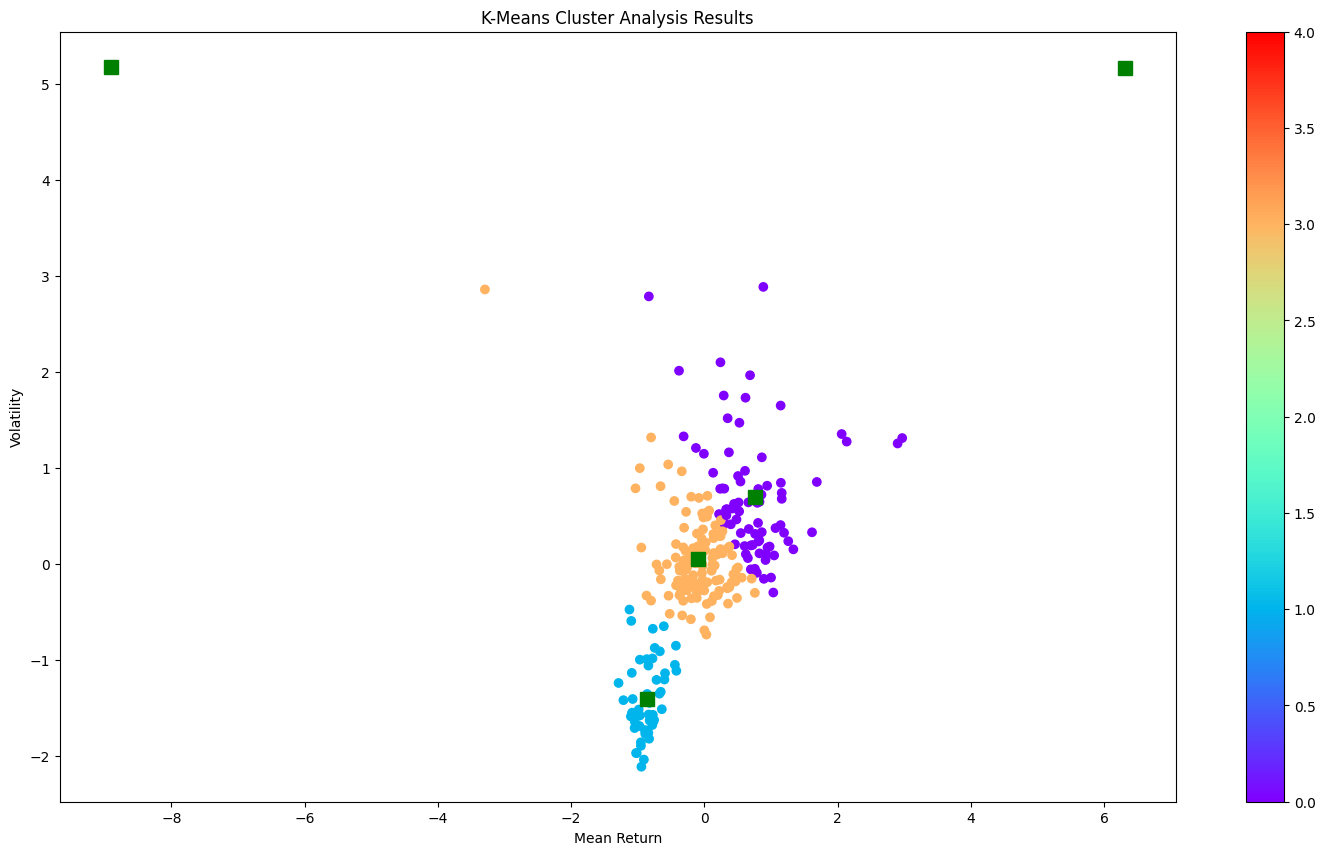

In [16]:
# Show Results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title("K-Means Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [17]:
# Return the series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series[:7]

AADR    3
AAXJ    3
ACWI    3
ACWX    3
AGNG    3
AGZD    1
AIA     3
dtype: int32

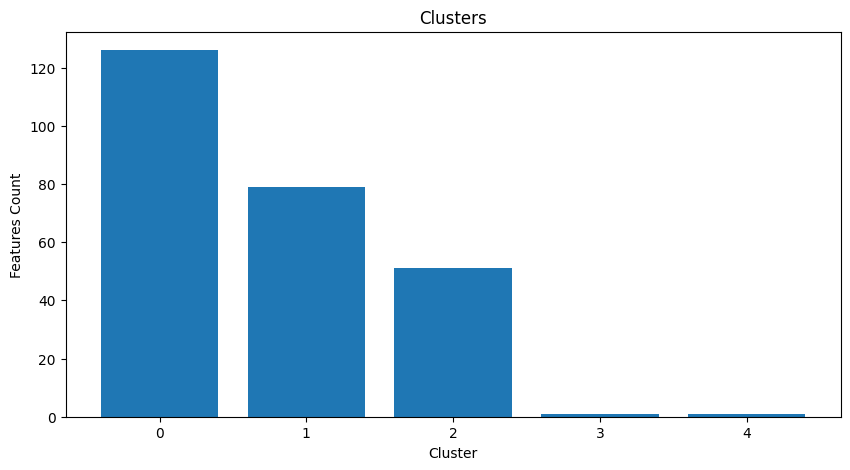

In [18]:
# View number by cluster
plt.figure(figsize=(10, 5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")
plt.show()

In [19]:
# Remove Items if Preferred
clusters_clean = clustered_series[clustered_series < 3]
print("Feature Number Previous: ", len(clustered_series))
print("Feature Number Current: ", len(clusters_clean))

Feature Number Previous:  258
Feature Number Current:  131
